We use "PDEFIND" method here to "discover" swift hohenberg from
its numerical simulations. Swift-Hohenberg reads
$$ u_t = -(\Delta+1)^2 u + Ru - u^3 $$
$$ \\ u_t = -\Delta^2 u -2\Delta u + (R-1)u - u^3 $$

We use the kutz approach of randomly sampling 150000 points in time and space,
and run the optimization on that data.

Our feature matrix will have the terms
$$1, u, u^2, u^3, u_x, u_y, u_x^2, u_y^2, u_y u_x, u_{xx}, u_{yy}, u_{xy},
 \Delta u, \Delta^2 u$$

 We use $$R=.5$$ for the data generation.

data shape:  (128, 128, 201)


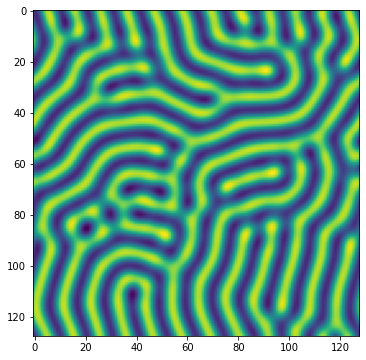

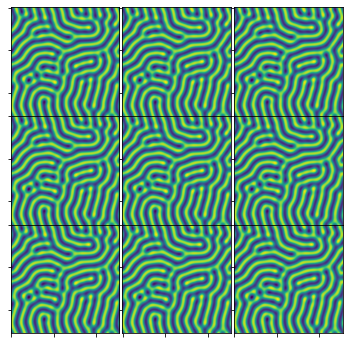

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from myPDEFIND import *
import math

data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/sh2.mat")

t = data['tt'].T[:,0]
x = data['xx'].T[0,:]
y = data['yy'].T[0,:]
U = data['uu']
print("data shape: ",np.shape(U))

nx = len(x)
ny = len(y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

#plot solution
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax1.imshow(U[:,:,100])

#validate periodicity- this means spectral derivatives are fine
fig = plt.figure(figsize=(6,6))
ax = [plt.subplot(3,3,i+1) for i in range(9)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
plt.subplots_adjust(wspace=0,hspace=0)
ax[0].imshow(U[:,:,100])
ax[1].imshow(U[:,:,100])
ax[2].imshow(U[:,:,100])
ax[3].imshow(U[:,:,100])
ax[4].imshow(U[:,:,100])
ax[5].imshow(U[:,:,100])
ax[6].imshow(U[:,:,100])
ax[7].imshow(U[:,:,100])
ax[8].imshow(U[:,:,100])

In [2]:
# Sample a collection of data points.  See figure 1 panel 2a.
np.random.seed(0) # so that numbers in paper are reproducible

num_xy = 5000 # needs to be very high to work with noise
num_t = 30
num_points = num_xy * num_t
boundary = 5
points = {}
count = 0

for p in range(num_xy):
    x_idx = np.random.choice(np.arange(boundary,nx-boundary),1)[0]
    y_idx = np.random.choice(np.arange(boundary,ny-boundary),1)[0]
    for t_idx in range(num_t):
        points[count] = [x_idx,y_idx,6*t_idx+10]
        count = count + 1

In [3]:
# Take up to second order derivatives.
u = np.zeros((num_points,1))
u_t = np.zeros((num_points,1))
u_x = np.zeros((num_points,1))
u_y = np.zeros((num_points,1))
u_xx = np.zeros((num_points,1))
u_yy = np.zeros((num_points,1))
u_xy = np.zeros((num_points,1))
lapu = np.zeros((num_points,1))
biharmu = np.zeros((num_points,1))

N = 2*boundary-1  # number of points to use in fitting
Nt = N
deg = 4

# setting parameters for spectral derivatives
Lx = 2*x[len(x)-1] # Size of enclosing periodic rectangle
Ly = 2*y[len(y)-1]

for p in points.keys():
    if p % 10000==0:
        print(p)
    [x_idx,y_idx,t_idx] = points[p]
    #u
    u[p] = U[x_idx,y_idx,t_idx]
    #u_t
    # u_t[p] = PolyDiffPoint(U[x_idx,y_idx,t_idx-(Nt-1)//2:t_idx+(Nt+1)//2], np.arange(Nt)*dt, deg, 1)
    u_t[p] = BackwardDiff(U[:,:,t_idx],U[:,:,t_idx-1],dt)[x_idx,y_idx]
    #u_x
    u_x[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'x')[x_idx,y_idx]
    #u_y
    u_y[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'y')[x_idx,y_idx]
    #u_xx
    u_xx[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'xx')[x_idx,y_idx]
    #u_yy
    u_yy[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'yy')[x_idx,y_idx]
    #u_xy
    u_xy[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'xy')[x_idx,y_idx]
    #lapu
    lapu[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'laplacian')[x_idx,y_idx]
    #biharmu
    biharmu[p] = SpectralDerivs(U[:,:,t_idx],Lx,Ly,'biharmonic')[x_idx,y_idx]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


Consruct $\Theta(U)$
We use for our library
$$ 1, u, u^2, u^3, u^4, u_x, u_y $$
$$u_x^2, u_y^2, u_yu_x, u_{xx}, u_{yy}, u_{xy}, \Delta u, \Delta^2 u$$

In [4]:
X = np.hstack([np.ones((num_points,1)), u, u**2, u**3,u**4,
                   u_x, u_y, u_x**2, u_y**2, u_x*u_y,
                   u_xx, u_yy, u_xy, lapu, biharmu])
description = ['','u','u^2','u^3','u^4',
               'u_{x}','u_{y}','u_{x}^2','u_{y}^2','u_{x}u_{y}',
               'u_{xx}','u_{yy}','u_{xy}','lapu','biharmu']

['1'] + description[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u^4',
 'u_{x}',
 'u_{y}',
 'u_{x}^2',
 'u_{y}^2',
 'u_{x}u_{y}',
 'u_{xx}',
 'u_{yy}',
 'u_{xy}',
 'lapu',
 'biharmu']

In [5]:
c = TrainSTRidge(X,u_t,10**-5,1)
print_pde(c, description)

u_t = (-0.492589 +0.000000i)u
    + (-0.995601 +0.000000i)u^3
    + (-119.142424 +0.000000i)u_{xx}
    + (-119.142645 +0.000000i)u_{yy}
    + (117.163113 +0.000000i)lapu
    + (-0.989566 +0.000000i)biharmu
   


In [6]:
X2 = np.hstack([np.ones((num_points,1)), u, u**2, u**3,u**4,
                   u_x, u_y, u_x**2, u_y**2, u_x*u_y,
                   u_xy, lapu, biharmu])
description2 = ['','u','u^2','u^3','u^4',
               'u_{x}','u_{y}','u_{x}^2','u_{y}^2','u_{x}u_{y}'
               ,'u_{xy}','lapu','biharmu']

['1'] + description2[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u^4',
 'u_{x}',
 'u_{y}',
 'u_{x}^2',
 'u_{y}^2',
 'u_{x}u_{y}',
 'u_{xy}',
 'lapu',
 'biharmu']

In [8]:
c2 = TrainSTRidge(X2,u_t,10**-5,1)
print_pde(c2, description2)

u_t = (-0.492635 +0.000000i)u
    + (-0.995591 +0.000000i)u^3
    + (-1.979442 +0.000000i)lapu
    + (-0.989556 +0.000000i)biharmu
   
